In [1]:
import pandas as pd
import os
import pickle
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import math 

## Get data

In [36]:
data_dir = '/cellar/users/zkoch/metallo_proj/data/'
out_dir = '/cellar/users/zkoch/metallo_proj/analysis_outputs'

In [4]:
methyl_df = pd.read_csv(os.path.join(data_dir,'beta_values.tsv'), sep = '\t')
# set IlmnID as index and transpose
methyl_df = methyl_df.set_index('IlmnID')
methyl_df = methyl_df.T
# remove index name
methyl_df.index.name = None

In [5]:
meta_df = pd.read_excel(os.path.join(data_dir, 'metadata.xlsx'))
# make 17th row the header#
meta_df.columns = meta_df.iloc[17]
# drop first 17 rows
meta_df = meta_df.drop(meta_df.index[0:18]).reset_index(drop=True)
meta_df['Sample Name'] = meta_df['Sample Name'].astype('str')
meta_df['Sample Name'] = meta_df['Sample Name'].replace(' ','_', regex=True)
meta_df = meta_df.set_index('Sample Name')

In [6]:
sample_sheet = pd.read_excel(os.path.join(data_dir, 'SampleSheet_Metallo_220722_fixed.xlsx'))
# drop first 6 rows
sample_sheet = sample_sheet.drop(sample_sheet.index[0:6]).reset_index(drop=True)
# make 1st row the header and drop first row
sample_sheet.columns = sample_sheet.iloc[0]
sample_sheet = sample_sheet.drop(sample_sheet.index[0]).reset_index(drop=True)
# set Sample Name as index
sample_sheet['Sample_Name'] = sample_sheet['Sample_Name'].astype(str)
sample_sheet = sample_sheet.set_index('Sample_Name', drop=True)
# combine sample_sheet and meta_df to allow pairing of methylation with metadata
meta_sample_df = meta_df.merge(sample_sheet, how='outer', left_index=True, right_index=True)

In [7]:
# merge meta_sample_df and methyl_df on 'IlmnID
meta_sample_df['IlmnID'] = meta_sample_df['Sentrix_ID'].astype(str) + '_' + meta_sample_df['Sentrix_Position'].astype(str)
# reset index and name the old index Sample
meta_sample_df = meta_sample_df.reset_index().rename(columns={'index':'sample_name'})
meta_sample_df = meta_sample_df.set_index('IlmnID')
# merge with methyl_df
methyl_df = methyl_df.merge(meta_sample_df['sample_name'], how='outer', left_index=True, right_index=True)
# set sample_name as index
methyl_df = methyl_df.set_index('sample_name', drop=True)

In [8]:
# put metadata and methylation data rows in same order
meta_df = meta_df.reindex(methyl_df.index)

In [60]:
# replace meta_df Genetic background WT (C57BL/6J) with C57BL/6J
meta_df['Genetic background'] = meta_df['Genetic background'].replace('WT (C57BL/6J)', 'C57BL/6J')

## Age distribution by diet and genetic background

<AxesSubplot:xlabel='Age (months)', ylabel='Count'>

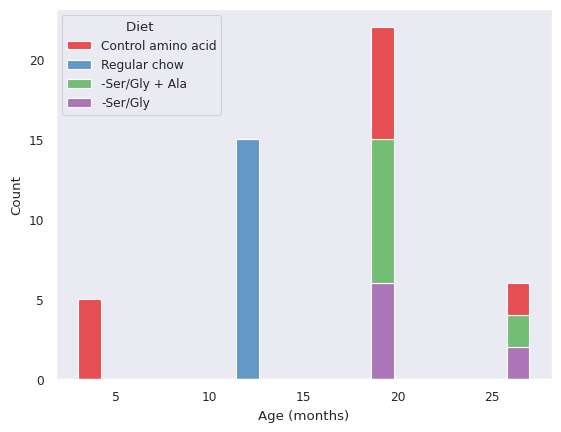

In [62]:
# plot histogram of ages for 'Diet' 
sns.histplot(data=meta_df, x='Age (months)', hue='Diet ', multiple='stack', bins=20, palette='Set1')

<AxesSubplot:xlabel='Age (months)', ylabel='Count'>

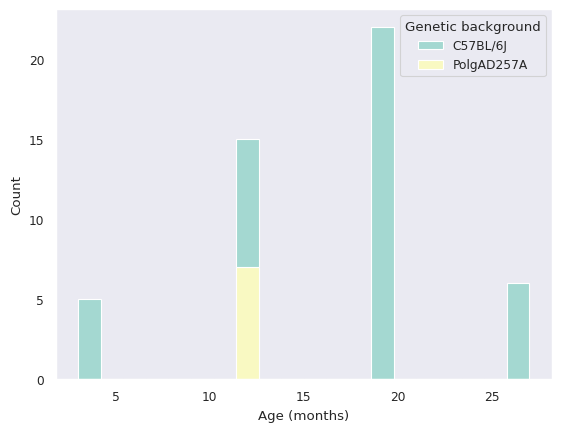

In [63]:
sns.histplot(data=meta_df, x='Age (months)', hue='Genetic background', multiple='stack', bins=20, palette='Set3')

## Train clocks

### ElasticNet

In [8]:
meta_df.columns

Index([  'Sample Code/Well ID',                'Gender',
                'Conc (ng/ul)',           'Volume (ul)',
                    'Total ng', 'Quantification Method',
                     'Comment',                     nan,
                'Age (months)',                 'Diet ',
                      'Gender',    'Genetic background'],
      dtype='object', name=17)

In [9]:
X = methyl_df.dropna(axis=1, how='any')
y = meta_df['Age (months)']

In [ ]:
# train elasticNetCV to predict age from methylation data
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

CV = KFold(n_splits = 5, shuffle = True, random_state = 0)

# create empty lists to store results
r2_scores = []
mse_scores = []
mae_scores = []
# iterate across folds
for train_index, test_index in CV.split(X):
    # split into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # fit model
    model = ElasticNetCV(cv=5, random_state=0).fit(X_train, y_train)
    # predict on test set
    y_pred = model.predict(X_test)
    # calculate scores
    r2_scores.append(r2_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    print("done with fold")


In [86]:
r2_scores

[0.8311728684833286,
 0.7537068281372044,
 0.9298355211233051,
 0.9533604093047388,
 0.9674650172909612]

In [87]:
mse_scores

[4.256131985535284,
 11.388596266935668,
 2.666951842103171,
 1.5961104371267174,
 1.800269043233481]

In [88]:
mae_scores

[1.575001879670511,
 2.227738645372417,
 1.2190692073902984,
 0.905304246336725,
 1.0153361270096266]

## Differential methylation

In [2]:
import methylize

/cellar/users/zkoch/miniconda3/envs/methylsuite/lib/python3.7/site-packages/methylize/diff_meth_pos.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### C57BL/6J by diet

##### Control amino acid vs -Ser/Gly + Ala

In [72]:
# limit to only strain C57BL/6J
meta_df_c57 = meta_df[meta_df['Genetic background'] == 'C57BL/6J']
# get the diet of each sample
c57_diets = meta_df_c57[(meta_df_c57['Diet '] == 'Control amino acid') | (meta_df_c57['Diet '] == '-Ser/Gly + Ala') ] 
# get methylation for these samples
methyl_df_c57 = methyl_df.loc[c57_diets.index, :]

In [ ]:
test_results = methylize.diff_meth_pos(methyl_df_c57, c57_diets, column='Diet ')

In [39]:
test_results.to_csv(os.path.join(out_dir, 'C57BL6J_controlAA_vs_-SERGLY+ALA_DMP.csv'))

In [33]:
test_results

,Coefficient,PValue,StandardError,fold_change,95%CI_lower,95%CI_upper,FDR_QValue
cg43651766_BC11,3.601082,0.026245,1.620237e+00,0.592724,-4.216,-3.919,0.397202
cg39898941_TC21,-12.676599,0.023886,5.611690e+00,-1.272025,0.824,1.223,0.397202
cg42531689_BC21,5.465657,0.017787,2.306153e+00,1.074593,-4.508,-4.283,0.397202
cg45344859_BC21,-4.317565,0.028997,1.977329e+00,-0.729704,1.230,1.549,0.397202
cg36733017_TC21,9.063979,0.011476,3.585637e+00,1.375823,-4.808,-4.610,0.397202
...,...,...,...,...,...,...,...
cg44513609_BC21,-0.000026,0.999976,8.648785e-01,-0.000005,-0.031,0.361,1.000000
cg30233042_BC11,-0.000003,0.999993,3.872826e-01,-0.000001,5.234,6.111,1.000000
cg46297879_BC21,-2086.884890,0.999987,1.245573e+08,-1.341152,-1.105,-0.714,1.000000
cg34850613_BC21,-0.000093,0.999961,1.890954e+00,-0.000011,2.286,2.465,1.000000


##### Control amino acid vs -Ser/Gly

In [40]:
# limit to only strain C57BL/6J
meta_df_c57 = meta_df[meta_df['Genetic background'] == 'C57BL/6J']
# get the diet of each sample
c57_diets = meta_df_c57[(meta_df_c57['Diet '] == 'Control amino acid') | (meta_df_c57['Diet '] == '-Ser/Gly') ] 
# get methylation for these samples
methyl_df_c57 = methyl_df.loc[c57_diets.index, :]

In [ ]:
test_results = methylize.diff_meth_pos(methyl_df_c57, c57_diets, column='Diet ')

In [79]:
test_results

,Coefficient,PValue,StandardError,fold_change,95%CI_lower,95%CI_upper,FDR_QValue
cg00101675_BC21,5.250794,0.009252,2.017532,0.788088,2.056,2.191,0.205374
cg40807440_TC21,3.327477,0.006654,1.226190,0.778062,3.013,3.284,0.205374
cg40807530_BC21,5.281906,0.018796,2.248042,0.487900,-4.796,-4.662,0.205374
cg40807554_BC21,9.306294,0.009504,3.588484,0.810441,-4.740,-4.623,0.205374
cg40808152_BC11,19.136994,0.006277,7.002310,0.406001,0.974,1.083,0.205374
...,...,...,...,...,...,...,...
cg36988032_TC21,-0.000179,0.999939,2.327701,-0.000021,2.497,2.600,0.999963
cg40239677_TC21,-0.000256,0.999918,2.497954,-0.000028,4.470,4.566,0.999963
cg43854700_BC21,-0.000078,0.999962,1.635716,-0.000013,3.285,3.431,0.999966
cg47107830_BC11,0.000064,0.999960,1.279858,0.000015,-4.990,-4.802,0.999966


In [44]:
test_results.to_csv(os.path.join(out_dir, 'C57BL6J_controlAA_vs_-SERGLY_DMP.csv'))

#### WT vs Polg

In [75]:
# limit to only strain WT (C57BL/6J) and PolgAD257A
meta_GB_subset_df = meta_df[(meta_df['Diet '] == 'Regular chow')]
# get methylation for these samples
methyl_GB_df = methyl_df.loc[meta_GB_subset_df.index, :]

In [ ]:
test_results = methylize.diff_meth_pos(methyl_GB_df, meta_GB_subset_df, column='Genetic background')

In [52]:
test_results[test_results['FDR_QValue'] < 0.05]

,Coefficient,PValue,StandardError,fold_change,95%CI_lower,95%CI_upper,FDR_QValue
cg29866807_BC21,-1.862728e+10,0.000000e+00,1.785084e+08,1.385200,0.520,0.730,0.000000e+00
cg41469188_TC21,-6.436292e+09,0.000000e+00,6.830876e+07,1.300575,1.342,1.494,0.000000e+00
cg35594333_BC11,-7.775020e+08,0.000000e+00,8.841915e+06,0.797423,5.404,5.613,0.000000e+00
cg32328790_BC21,-5.262055e+09,0.000000e+00,7.252008e+07,1.569714,-1.964,-1.781,0.000000e+00
cg35789237_TC21,-1.175406e+10,0.000000e+00,1.431515e+08,1.128068,0.843,1.019,0.000000e+00
cg38753337_TC21,-1.061895e+10,0.000000e+00,1.314617e+08,1.619409,0.853,1.126,0.000000e+00
cg44176882_BC21,-5.401545e+09,0.000000e+00,6.450828e+07,1.170543,1.871,2.238,0.000000e+00
cg40548351_TC21,1.122457e+09,1.083266e-226,3.492003e+07,-0.963925,3.888,4.108,3.329891e-222
cg46736886_TC21,1.851688e+09,1.937124e-100,8.703606e+07,-2.020366,-1.637,-1.534,5.292975e-96


In [53]:
test_results.to_csv(os.path.join(out_dir, 'WT_vs_PolgAD257A_DMP_sameAge.csv'))

In [81]:
test_results = pd.read_csv(os.path.join(out_dir, 'WT_vs_PolgAD257A_DMP_sameAge.csv'), index_col=0)

INFO:methylprep.files.manifests:Reading manifest file: MM285_manifest_v3.csv
INFO:methylprep.files.manifests:Reading manifest file: MM285_manifest_v3.csv
Calculating ACF out to: 121
with 5  lags: [1, 31, 61, 91, 121]
10667861 bases used as coverage for sidak correction
INFO:methylize.diff_meth_regions:wrote: data.regions-p.bed.gz, (regions with corrected-p < 0.05: 6)


34 NaNs dropped


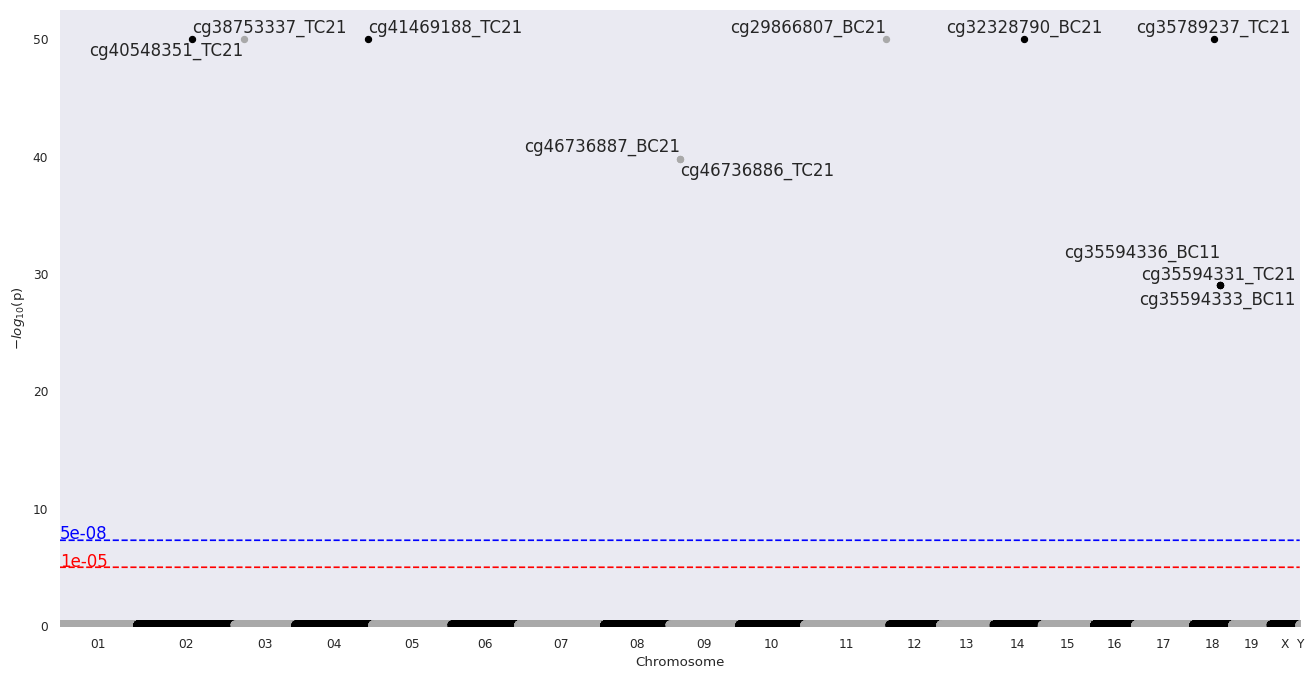

INFO:methylize.genome_browser:Loaded 8 CpG regions from data_regions.csv.
INFO:methylize.genome_browser:Downloading refGene
INFO:methylize.genome_browser:Cached /cellar/users/zkoch/miniconda3/envs/methylsuite/lib/python3.7/site-packages/methylize/data/refGene.pkl on first use, with 133871 genes
Mapping genes: 100%|██████████| 133871/133871 [00:42<00:00, 3182.41it/s]
INFO:methylize.genome_browser:Wrote data_regions_genes.csv


In [83]:
bed = methylize.diff_meth_regions(test_results, 'mouse', prefix='data', plot=True)

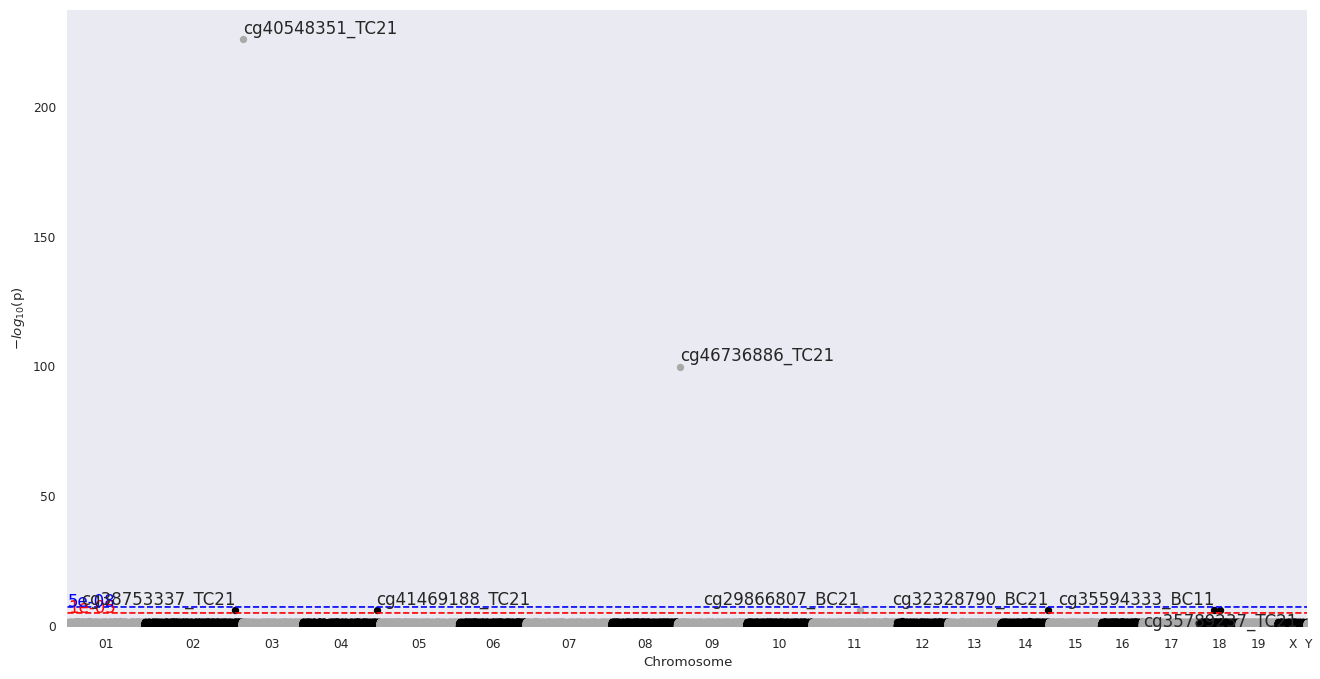

In [59]:
methylize.manhattan_plot(test_results, 'mouse')

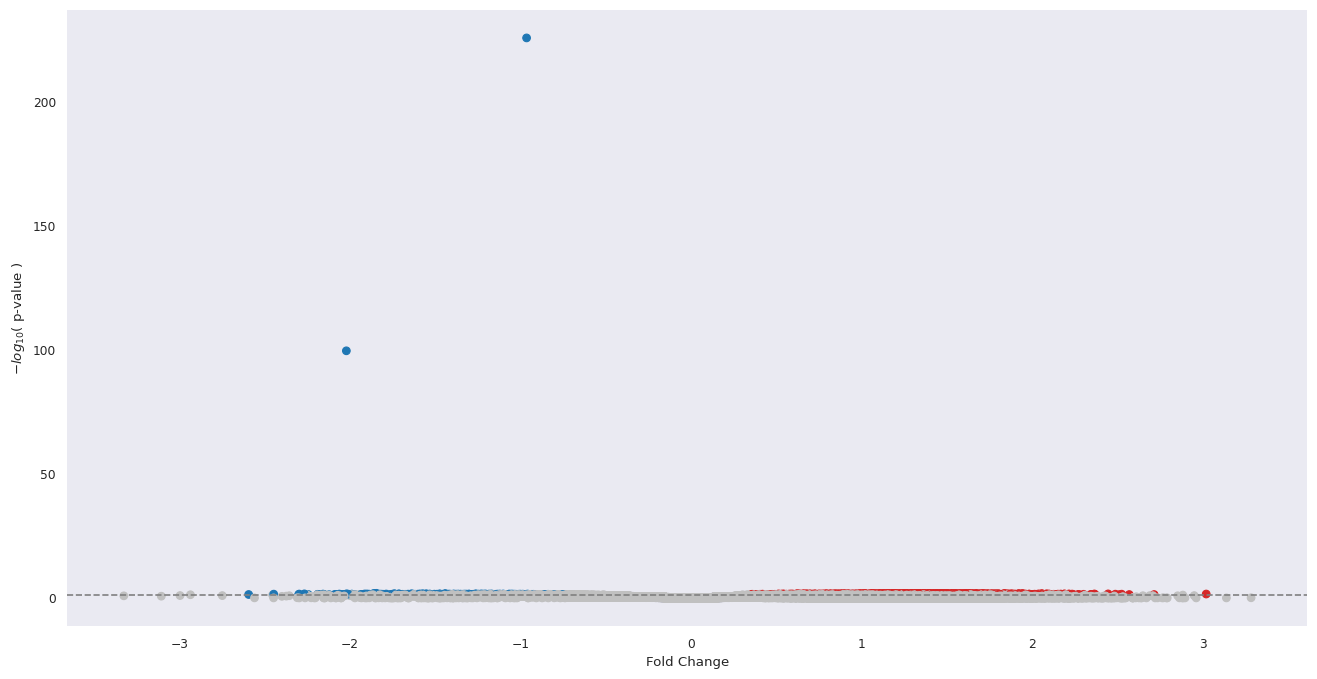

In [57]:
methylize.volcano_plot(test_results)